# Network continuity with OSM data

## Preparation

Set the coordinates and buffer distances to your preferred extents.


In [7]:
from shapely import geometry

from cityseer.tools import plot, io

lng, lat = -1.7063649924889566, 52.19277374082795  # stratford-upon-avon
# lng, lat = -0.13039709427587876, 51.516434828344366  # london
# lng, lat = 18.425702641104582, -33.9204746754594  # cape town
# lng, lat = 29.01011384485918, 41.021325648742206  # istanbul
buffer_dist = 5000
plot_buffer = 3500
poly_wgs, poly_utm, _utm_zone_number, _utm_zone_letter = io.buffered_point_poly(lng, lat, buffer_dist)
# select extents for plotting
plot_bbox = poly_utm.centroid.buffer(plot_buffer).bounds

INFO:cityseer.tools.io:UTM conversion info: UTM zone number: 30, UTM zone letter: U


## Loading data from OSM

For this example, we'll use a custom OSM query that excludes footways because the continuity analysis needs OSM ways that have street name or route number information.

For this form of analysis, only basic cleaning is recommended:
- not consolidating nodes because this risks accidentally dropping highway / ref / name attributes
- not like closeness or betweenness methods, where topological distortions are arguably a bigger issue

In [8]:
query = """
[out:json];
(
    way["highway"]
    ["area"!="yes"]
    ["highway"!~"footway|pedestrian|steps|bus_guideway|escape|raceway|proposed|planned|abandoned|platform|construction"]
    ["service"!~"parking_aisle"]
    ["amenity"!~"charging_station|parking|fuel|motorcycle_parking|parking_entrance|parking_space"]
    ["access"!~"private|customers"]
    ["indoor"!="yes"]
    (poly:"{geom_osm}");
);
out body;
>;
out qt;
"""
G_osm = io.osm_graph_from_poly_wgs(
    poly_wgs, custom_request=query, simplify=True, remove_parallel=False, iron_edges=False
)

INFO:cityseer.tools.graphs:Converting networkX graph from WGS to UTM.
INFO:cityseer.tools.graphs:Processing node x, y coordinates.
100%|██████████| 14492/14492 [00:00<00:00, 17401.06it/s]
INFO:cityseer.tools.graphs:UTM conversion info: UTM zone number: 30, UTM zone letter: U
INFO:cityseer.tools.graphs:Processing edge geom coordinates, if present.
100%|██████████| 14986/14986 [00:00<00:00, 914785.69it/s]
INFO:cityseer.tools.graphs:Generating simple (straight) edge geometries.
100%|██████████| 14986/14986 [00:00<00:00, 44741.52it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 14492/14492 [00:02<00:00, 6325.46it/s]
INFO:cityseer.tools.graphs:Removing dangling nodes.
100%|██████████| 3307/3307 [00:00<00:00, 254244.51it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 2973/2973 [00:00<00:00, 65780.08it/s]
INFO:cityseer.tools.graphs:Consolidating nodes.
100%|██████████| 2859/2859 [00:00<00:00, 10635.29it/s]
INFO:cityseer.tools.graphs:Removing fille

## Observe continuity metrics

We can now run the contunity metrics

100%|██████████| 3271/3271 [00:02<00:00, 1239.01it/s]


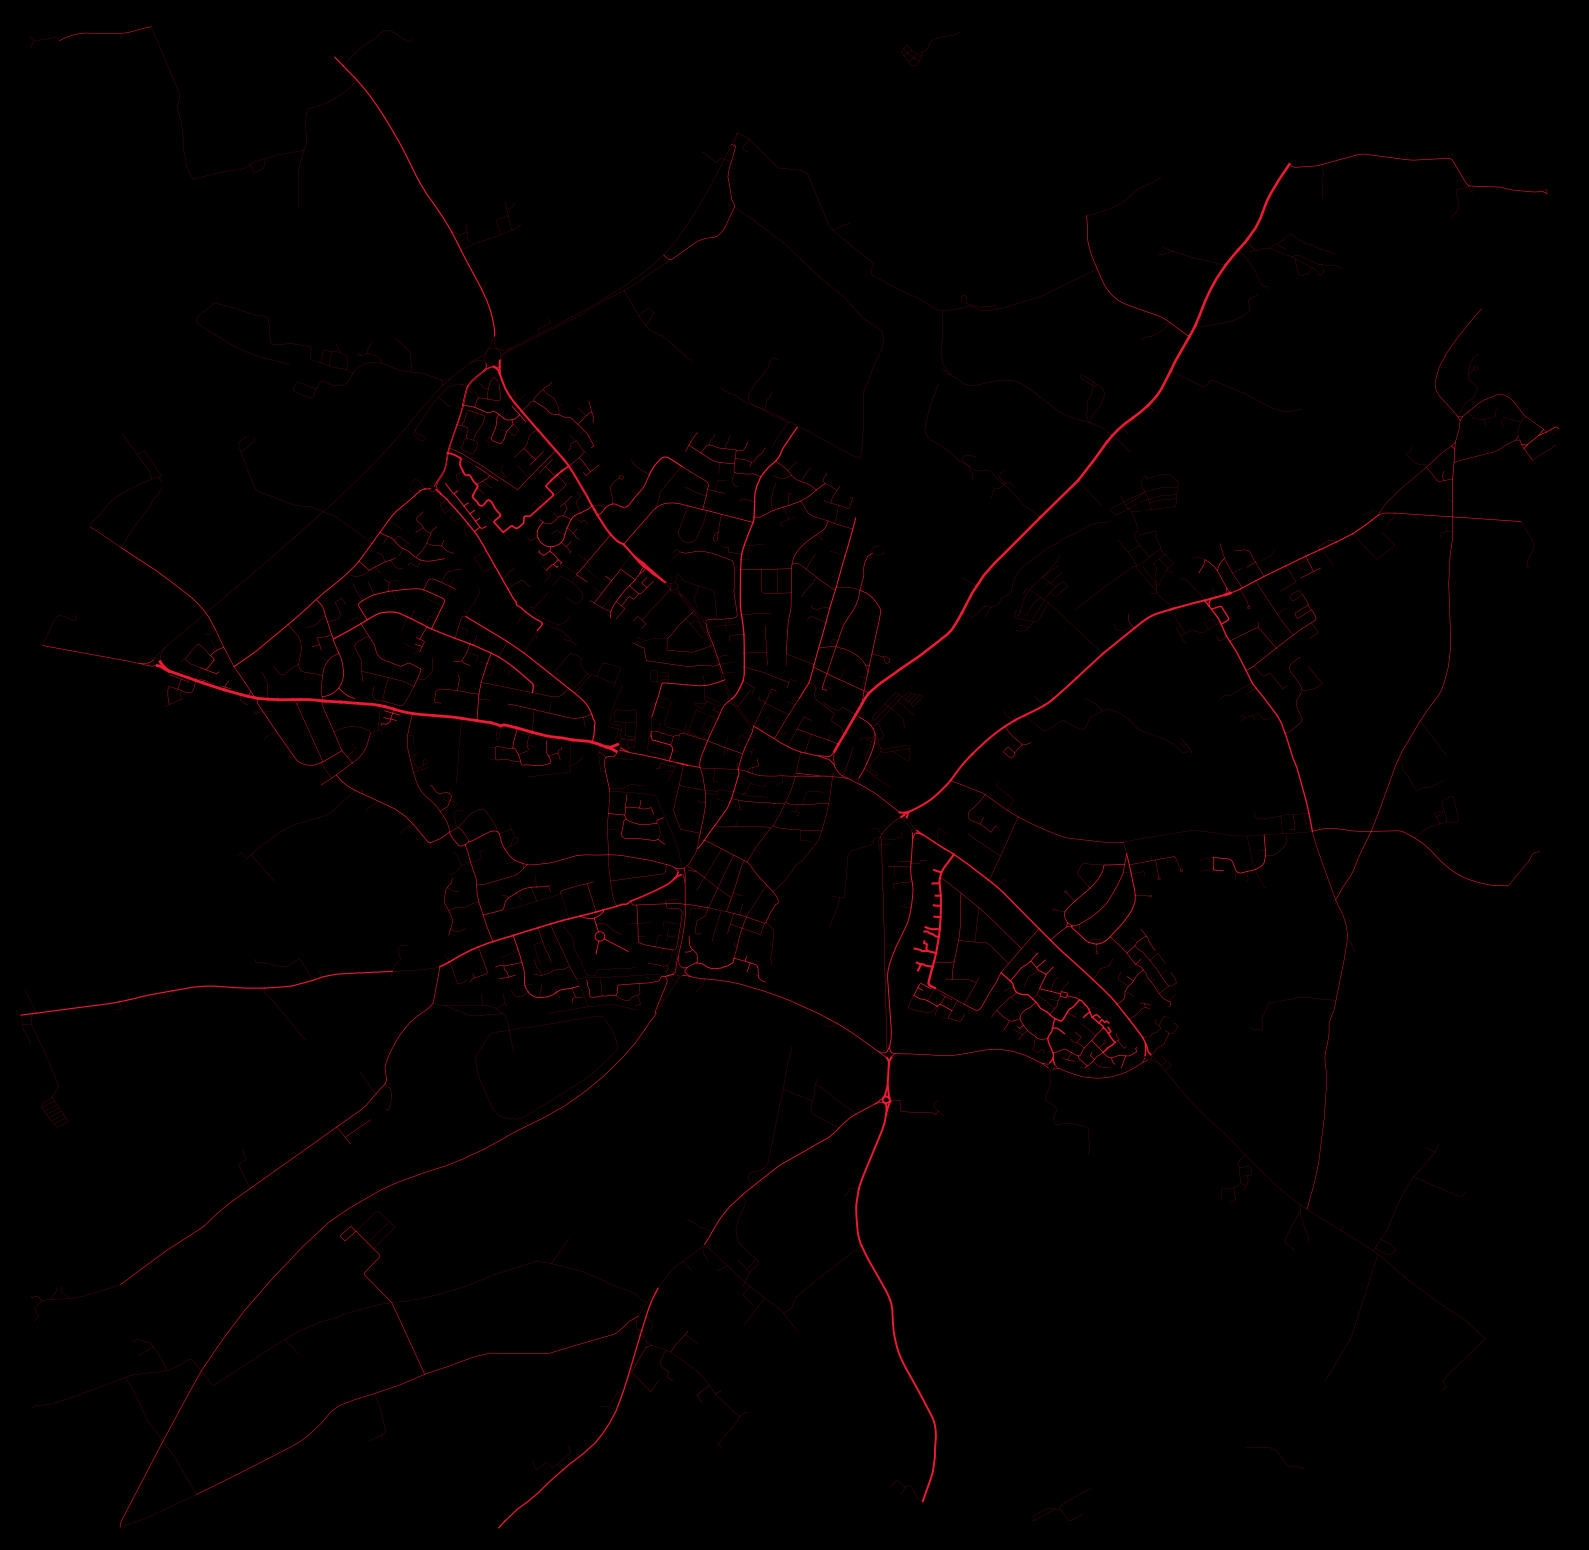

100%|██████████| 3271/3271 [00:02<00:00, 1440.32it/s]


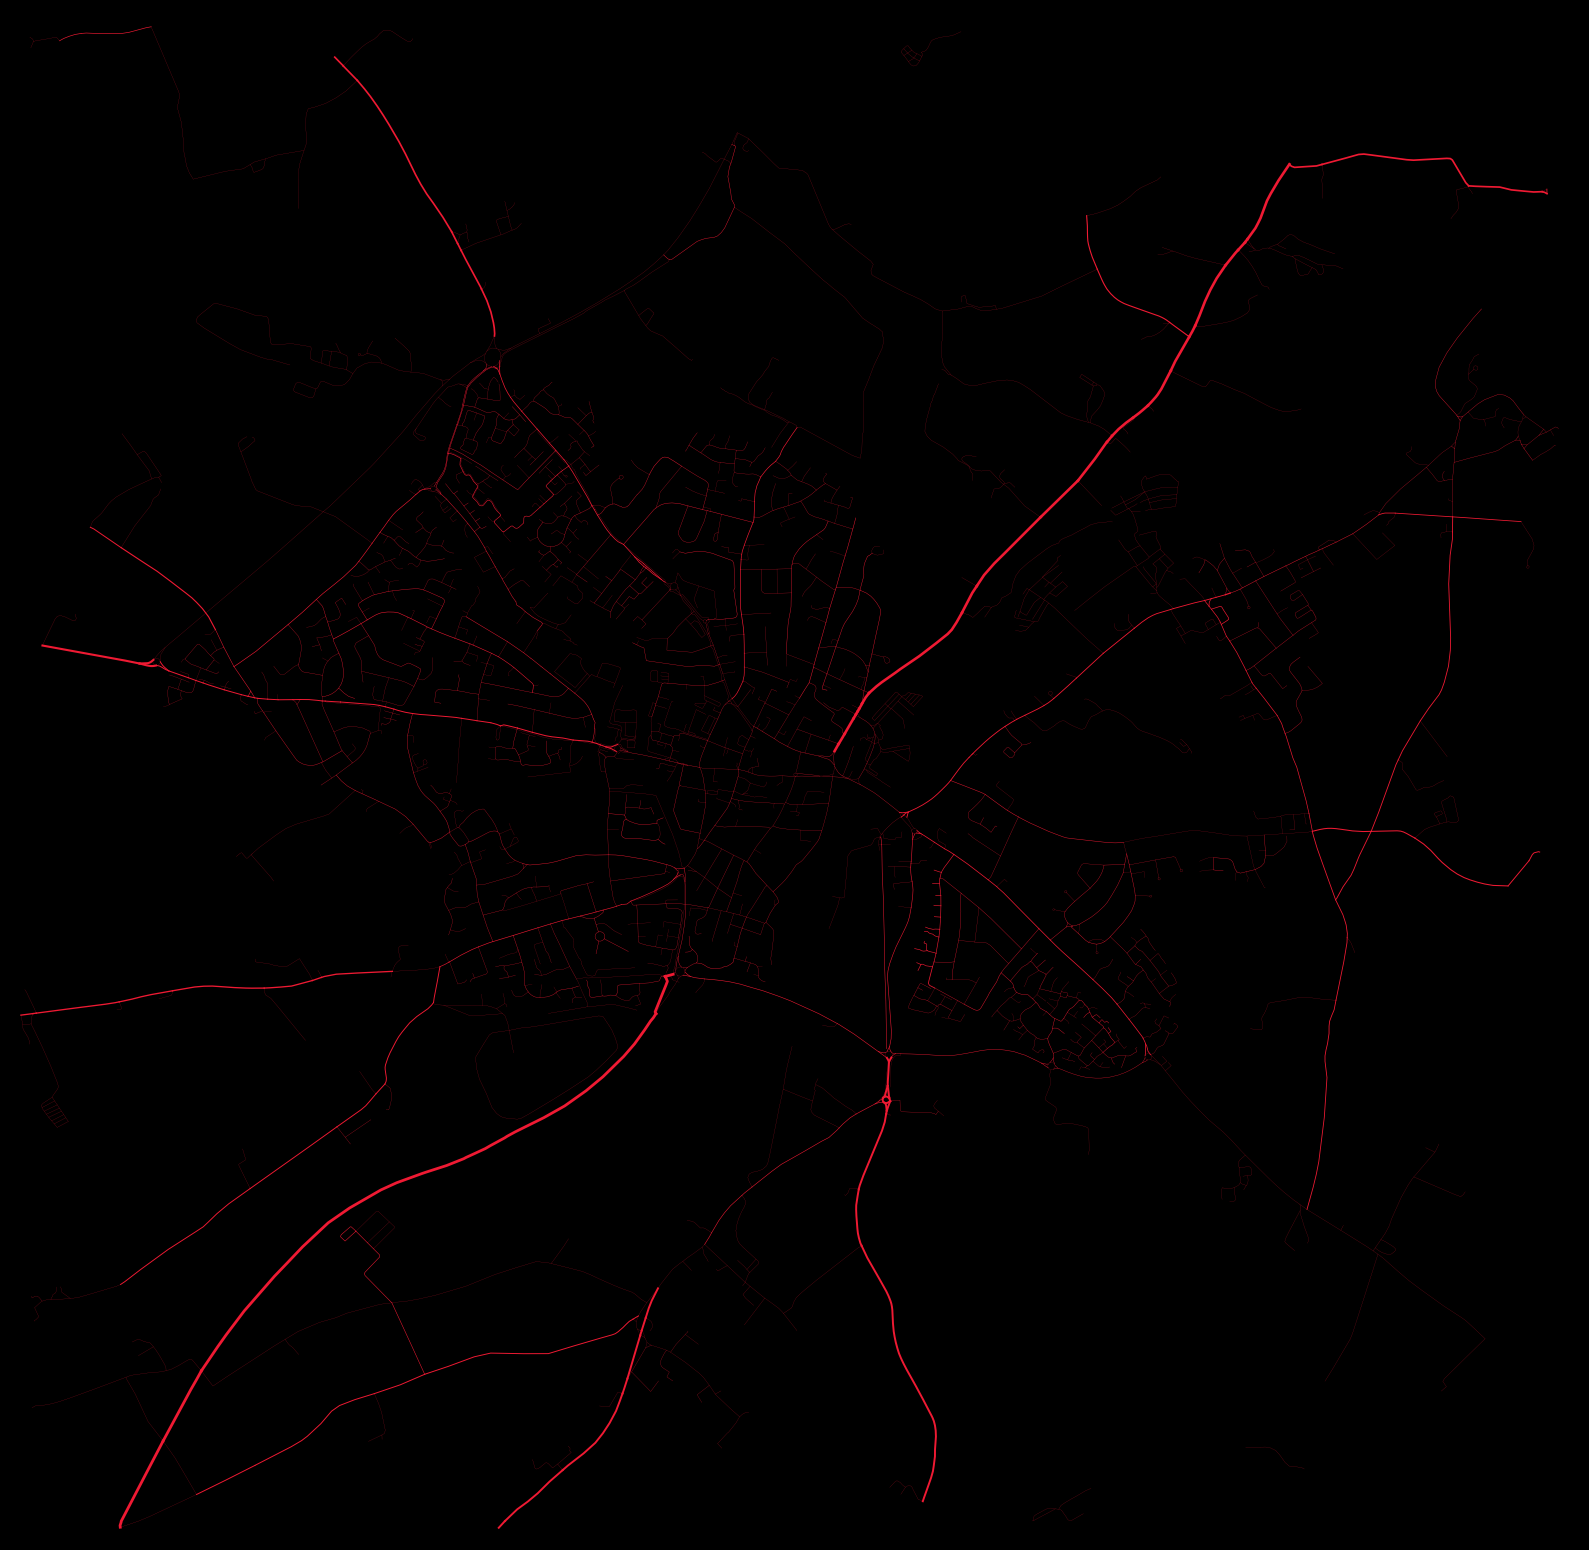

In [9]:
import matplotlib.pyplot as plt

from cityseer.metrics import observe

from demos.general_util import plot_funcs

# methods can be "names", "refs", "highways"
G_cont = observe.route_continuity(G_osm, method="names")

# plot
_fig, ax = plt.subplots(1, 1, dpi=200, figsize=(10, 10))
plot_funcs.plot_nx_edges(ax, G_cont, "names_agg_count", plot_bbox)
plt.show()
_fig, ax = plt.subplots(1, 1, dpi=200, figsize=(10, 10))
plot_funcs.plot_nx_edges(ax, G_cont, "names_agg_length", plot_bbox)
plt.show()